SMB、HML两个指标的计算方式如下：
1. 首先，按市值大小平均分为两组(Small 组, Big 组)，基准是这一时间的市场上公司市值中位数;
2. 按 BM 从小到大分三组,即前 30%(Growth 组),中间 40%(Neutral 组),后 30%(Value 组)；
3. 每个组的月回报以组内所有成员股票当月回报的加权平均数为依据,计算每个月的 SMB 和 HML 值。具体计算公式如下: 
   SMB = Small size return - Big size return)
   HML = Value company return - Growth company return
4. 以市场回报减去无风险回报,即得到超额市场回报(Rm-Rf)。（由于Ricequant平台无法提取国债收益率，我只能对这个时段的所有IBO1M求平均值作为无风    险回报率

In [1]:
%pdb

Automatic pdb calling has been turned ON


In [2]:
# %load fama.py
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta


In [3]:
research_starttime='2010-04-01'
research_endtime='2018-04-01'
format='%Y-%m-%d %H:%M:%S'
data_type=""#"net"
data_mode=""#"fast"

### 定义基础数据获取函数

In [4]:
## 从网络获取数据
def get_dp():
        interval_month=24
        # date_range=pd.date_range(research_starttime,research_endtime)
        # len(date_range)/31
        # pd.to_datetime(research_endtime)-(pd.to_datetime(research_endtime)-pd.to_datetime(research_starttime))/4
        # print(datetime.date.today() +relativedelta(months=-1))
        step0=pd.to_datetime(research_endtime)
        step1=pd.to_datetime(research_endtime)-relativedelta(months=interval_month*1)
        step2=pd.to_datetime(research_endtime)-relativedelta(months=interval_month*2)
        step3=pd.to_datetime(research_endtime)-relativedelta(months=interval_month*3)
        step4=pd.to_datetime(research_endtime)-relativedelta(months=interval_month*4)
        
        #网络请求API
        def get_years_fundamentals(interval_month,enddate):
            return get_fundamentals(
                query(fundamentals.eod_derivative_indicator.market_cap,fundamentals.financial_indicator.book_value_per_share)
                ,enddate, str(interval_month)+'m')
        
        # arr data
        dp_arr = [get_years_fundamentals(interval_month,step0),
                  get_years_fundamentals(interval_month,step1),
                  get_years_fundamentals(interval_month,step2),
                  get_years_fundamentals(interval_month,step3)]
        dp_arr
        
        # merge data 
        dp_merge=pd.concat(dp_arr,axis=1)#,ignore_index=True
        return dp_merge
        
#转换索引
def trans_index(df):
    if(type(df.index[0])==str):
        df.index=pd.to_datetime(df.index)
    return df
        
#get_all_instruments
def all_instruments_cs():
    df_market=None
    if(data_type=="net"):
        df_market = all_instruments(type='CS')
    else:
        df_market=pd.read_csv("all_instruments.csv",index_col=0)
    return df_market

#get_price_cs
def get_price_cs(data_starttime,data_endtime):
    df_price_data=None
    df_market=all_instruments_cs()
    if(data_type=="net"):
        df_price_data = get_price(list(df_market['order_book_id']),start_date=data_starttime, end_date=data_endtime,frequency='1d',fields='close')
    else:
        df_price_data=pd.read_csv("price_data.csv",index_col=0)
        df_price_data=trans_index(df_price_data)
    return df_price_data

#转换Series
def trans_series(df,key=1):
    if(type(df)==pd.DataFrame):
        df=df[key]
    return df


In [5]:
df_book_value=None
df_market_cap=None

#网络获取方式
if(data_type=="net"):
    dp_merge=get_dp()
    df_book_value=dp_merge["book_value_per_share"]
    df_market_cap=dp_merge["market_cap"]
else:
#本地获取方式
    df_book_value=pd.read_csv("./book_value_per_share.csv",index_col=0)
    df_market_cap=pd.read_csv("./market_cap.csv",index_col=0)
    df_book_value=trans_index(df_book_value)
    df_market_cap=trans_index(df_market_cap)

In [6]:
df_book_value

000001.XSHE  000002.XSHE  000004.XSHE  000005.XSHE  000006.XSHE  \
2018-03-30        11.77      12.0200       1.3740       1.1962       4.1242   
2018-02-28        11.54      10.5418       1.3740       1.1962       3.7787   
2018-01-26        11.54      10.5418       1.3740       1.1962       3.7787   
2017-12-26        11.54      10.5418       1.3740       1.1962       3.7787   
2017-11-24        11.54      10.5418       1.3740       1.1962       3.7787   
2017-10-24        11.54      10.2000       1.3938       1.1948       3.7124   
2017-09-22        11.15      10.2000       1.3938       1.1948       3.7124   
2017-08-22        11.15      10.3242       1.4247       1.2020       3.7124   
2017-07-21        10.94      10.3242       1.4247       1.2020       3.7844   
2017-06-21        10.94      10.3242       1.4247       1.2020       3.7844   
2017-05-19        10.94      10.3242       1.4247       1.2020       3.7844   
2017-04-19        10.61      10.2800       1.4387       1.2115       3.7075   
2017-03-17        10.61       9.1000       1.1458       1.2115       3.2185   
2017-02-17        10.38       9.1000       1.1458       1.2115       3.2185   
2017-01-17        10.38       9.1000       1.1458       1.2115       3.2185   
2016-12-16        10.38       9.1000       1.1458       1.2115       3.2185   
2016-11-16        10.38       9.1000       1.1458       1.2115       3.2185   
2016-10-14        10.00       8.8300       1.0063       1.2051       3.2088   
2016-09-14        10.00       8.8300       1.0063       1.2051       3.2088   
2016-08-12        10.00       9.1200       0.9422       1.0787       3.2895   
2016-07-12        11.71       9.1200       0.9422       1.0787       3.2895   
2016-06-08        11.71       9.1200       0.9422       1.0787       3.2895   
2016-05-06        11.71       9.1200       0.9422       1.0787       3.2895   
2016-04-06         9.41       9.0800       0.9851       0.6998       3.2541   
2016-04-01         9.41       9.0800       0.9851       0.6998       3.2541   
2016-03-01        10.98       8.0500       0.9851       0.6998       3.1496   
2016-02-01        10.98       8.0500       0.9851       0.6998       3.1496   
2015-12-31        10.98       8.0500       0.9851       0.6998       3.1496   
2015-11-30        10.98       8.0500       0.9851       0.6998       3.1496   
2015-10-30        10.98       8.0500       0.9703       0.6998       3.1496   
...                 ...          ...          ...          ...          ...   
2012-09-14        15.58       5.0100       0.8877       0.6900       3.1600   
2012-08-14        14.99       5.0100       0.8877       0.7080       3.1600   
2012-07-13        14.99       4.9400       0.8972       0.7080       2.9400   
2012-06-13        14.99       4.9400       0.8972       0.7080       2.9400   
2012-05-11        14.99       4.9400       0.8972       0.7080       2.9400   
2012-04-11        14.31       4.8200       0.8702       0.7680       2.7200   
2012-03-30        14.31       4.8200       0.8702       0.7680       2.7200   
2012-02-29        13.61       4.2700       0.8702       0.7680       2.7200   
2012-01-20        13.61       4.2700       0.8702       0.7680       2.7200   
2011-12-20        13.61       4.2700       0.8702       0.7680       2.7200   
2011-11-18        13.61       4.2700       0.8702       0.7680       2.7200   
2011-10-18        10.95       4.2000       0.8671       0.7820       2.5800   
2011-09-16        10.95       4.2000       0.8671       0.7820       2.5800   
2011-08-16        10.32       4.2000       0.8659       0.7500       2.5800   
2011-07-15        10.32       4.1400       0.8659       0.7500       3.2900   
2011-06-15        10.32       4.1400       0.8659       0.7500       3.2900   
2011-05-13        10.32       4.1400       0.8659       0.7500       3.2900   
2011-04-13         9.53       4.0200       0.8411       0.7390       3.2300   
2011-03-11         9.53       4.0200       0.8411       0.7390

In [7]:
df_market_cap

000001.XSHE   000002.XSHE   000004.XSHE   000005.XSHE  \
2018-03-30  1.871575e+11  3.674934e+11  1.918867e+09  4.085952e+09   
2018-02-28  2.069035e+11  3.609803e+11  1.729920e+09  4.043611e+09   
2018-01-26  2.412443e+11  4.420076e+11  1.817255e+09  4.477611e+09   
2017-12-26  2.345478e+11  3.366941e+11  1.884437e+09  4.340001e+09   
2017-11-24  2.500012e+11  3.510450e+11  2.305160e+09  4.456440e+09   
2017-10-24  1.955710e+11  2.980571e+11  2.099417e+09  5.165660e+09   
2017-09-22  1.964295e+11  3.069988e+11  2.038114e+09  5.419709e+09   
2017-08-22  1.828649e+11  2.562187e+11  1.925585e+09  5.112733e+09   
2017-07-21  1.869858e+11  2.735502e+11  1.805499e+09  5.197416e+09   
2017-06-21  1.571093e+11  2.322638e+11  2.231260e+09  5.694928e+09   
2017-05-19  1.492109e+11  2.116205e+11  3.023161e+09  5.557318e+09   
2017-04-19  1.529884e+11  2.266338e+11  3.023161e+09  6.552343e+09   
2017-03-17  1.598565e+11  2.377833e+11  3.249898e+09  6.933416e+09   
2017-02-17  1.612302e+11  2.267442e+11  3.165921e+09  6.975758e+09   
2017-01-17  1.571093e+11  2.296144e+11  3.138209e+09  6.859319e+09   
2016-12-16  1.588263e+11  2.479394e+11  3.734443e+09  7.335660e+09   
2016-11-16  1.584829e+11  2.945246e+11  3.988053e+09  8.013124e+09   
2016-10-14  1.560790e+11  2.962908e+11  3.291886e+09  8.023709e+09   
2016-09-14  1.555639e+11  2.603032e+11  3.092861e+09  7.780246e+09   
2016-08-12  1.631189e+11  2.514719e+11  3.092861e+09  7.706148e+09   
2016-07-12  1.524733e+11  2.000294e+11  3.092861e+09  7.981368e+09   
2016-06-08  1.502411e+11  2.699643e+11  3.092861e+09  7.473270e+09   
2016-05-06  1.505273e+11  2.699643e+11  3.092861e+09  7.473270e+09   
2016-04-06  1.533890e+11  2.699643e+11  3.092861e+09  8.362441e+09   
2016-04-01  1.525305e+11  2.699643e+11  3.092861e+09  7.970782e+09   
2016-03-01  1.387942e+11  2.699643e+11  2.359745e+09  7.600295e+09   
2016-02-01  1.402250e+11  2.699643e+11  2.341270e+09  7.325075e+09   
2015-12-31  1.715610e+11  2.699643e+11  3.854530e+09  1.062771e+10   
2015-11-30  1.679839e+11  1.665314e+11  3.345631e+09  8.521589e+09   
2015-10-30  1.625466e+11  1.510482e+11  2.729242e+09  9.335346e+09   
...                  ...           ...           ...           ...   
2012-09-14  7.198307e+10  9.170005e+10  7.154813e+08  2.688141e+09   
2012-08-14  7.818233e+10  9.433890e+10  6.911281e+08  2.752144e+09   
2012-07-13  7.674779e+10  1.084128e+11  8.901528e+08  2.550991e+09   
2012-06-13  7.603052e+10  1.019256e+11  7.809832e+08  3.172738e+09   
2012-05-11  8.207607e+10  9.818723e+10  7.297574e+08  3.300744e+09   
2012-04-11  8.110264e+10  9.334933e+10  7.389948e+08  3.529328e+09   
2012-03-30  8.048784e+10  9.104034e+10  6.827304e+08  3.529328e+09   
2012-02-29  8.760929e+10  9.104034e+10  7.919001e+08  3.529328e+09   
2012-01-20  8.596982e+10  8.686216e+10  6.827304e+08  3.529328e+09   
2011-12-20  7.854096e+10  8.246408e+10  7.583095e+08  3.529328e+09   
2011-11-18  8.171744e+10  7.795604e+10  9.338207e+08  3.529328e+09   
2011-10-18  8.207607e+10  7.905556e+10  8.817552e+08  3.529328e+09   
2011-09-16  8.709696e+10  8.862139e+10  1.014438e+09  3.529328e+09   
2011-08-16  8.735312e+10  9.191996e+10  1.023676e+09  3.529328e+09   
2011-07-15  6.269540e+10  9.268962e+10  1.054747e+09  3.529328e+09   
2011-06-15  5.666632e+10  8.873135e+10  1.126967e+09  3.529328e+09   
2011-05-13  6.158019e+10  9.137020e+10  1.140403e+09  3.529328e+09   
2011-04-13  6.290450e+10  9.818723e+10  1.182392e+09  3.895061e+09   
2011-03-11  5.593447e+10  9.159010e+10  1.154679e+09  3.876774e+09   
2011-02-11  5.401771e+10  9.082044e+10  1.074902e+09  3.538471e+09   
2011-01-11  5.642237e+10  9.928675e+10  1.008560e+09  3.465324e+09   
2010-12-10  5.694512e+10  8.906120e+10  1.039631e+09  3.492754e+09   
2010-11-10  6.318330e+10  1.006062e+11  1.137884e+09  4.096215e+09   
2010-10-08  6.001194e+10  9.279957e+10  9.606933e+08  4.004781e+09   
2010-09-08  6.151049e+10  9.422895e+10  9.497763e+08  4.370515e+09   
2010-08-06  6.102259e+1

计算说明：
dp_merge.major_xs("2018-03-30")


In [8]:
df_book_value=df_book_value.dropna(axis=1,how="all")
df_market_cap=df_market_cap.dropna(axis=1,how="all")
index_date = df_book_value.index
print("index_date",index_date)
stocks = df_book_value.columns

data_endtime=index_date[0]
data_count=len(index_date)
data_starttime=index_date[data_count-1]


index_date DatetimeIndex(['2018-03-30', '2018-02-28', '2018-01-26', '2017-12-26',
               '2017-11-24', '2017-10-24', '2017-09-22', '2017-08-22',
               '2017-07-21', '2017-06-21', '2017-05-19', '2017-04-19',
               '2017-03-17', '2017-02-17', '2017-01-17', '2016-12-16',
               '2016-11-16', '2016-10-14', '2016-09-14', '2016-08-12',
               '2016-07-12', '2016-06-08', '2016-05-06', '2016-04-06',
               '2016-04-01', '2016-03-01', '2016-02-01', '2015-12-31',
               '2015-11-30', '2015-10-30', '2015-09-30', '2015-08-28',
               '2015-07-28', '2015-06-26', '2015-05-26', '2015-04-24',
               '2015-03-24', '2015-02-17', '2015-01-16', '2014-12-16',
               '2014-11-14', '2014-10-14', '2014-09-12', '2014-08-12',
               '2014-07-11', '2014-06-11', '2014-05-09', '2014-04-09',
               '2014-04-01', '2014-02-28', '2014-01-28', '2013-12-27',
               '2013-11-27', '2013-10-25', '2013-09-25', '2013-08-

In [9]:
# index_date

In [10]:
#all_instruments_cs
df_market = all_instruments_cs()
print("df_market['order_book_id']=",len(df_market['order_book_id']),df_market['order_book_id']);

df_market['order_book_id']= 3631 0       002322.XSHE
1       601877.XSHG
2       002480.XSHE
3       002735.XSHE
4       000839.XSHE
5       603966.XSHG
6       300521.XSHE
7       002202.XSHE
8       300160.XSHE
9       002025.XSHE
10      002011.XSHE
11      600261.XSHG
12      000759.XSHE
13      603421.XSHG
14      600635.XSHG
15      300151.XSHE
16      000776.XSHE
17      002702.XSHE
18      000968.XSHE
19      002013.XSHE
20      000756.XSHE
21      600672.XSHG
22      300095.XSHE
23      300553.XSHE
24      002718.XSHE
25      603089.XSHG
26      002205.XSHE
27      000951.XSHE
28      300302.XSHE
29      300515.XSHE
           ...     
3601    002490.XSHE
3602    603685.XSHG
3603    002156.XSHE
3604    600966.XSHG
3605    600606.XSHG
3606    002453.XSHE
3607    300255.XSHE
3608    603458.XSHG
3609    300379.XSHE
3610    000875.XSHE
3611    000667.XSHE
3612    600583.XSHG
3613    300223.XSHE
3614    002569.XSHE
3615    300359.XSHE
3616    300050.XSHE
3617    002157.XSHE
3618   

In [11]:
df_price_data = get_price_cs(data_starttime,data_endtime)

In [12]:
#save data to reuse offline
# df_book_value.to_csv("book_value_per_share.csv")
# df_market_cap.to_csv("market_cap.csv")
# df_market.to_csv("all_instruments.csv")
# df_price_data.to_csv("price_data.csv")

In [13]:
# df_price_data.dropna(axis=1,how="all")

In [14]:
df_book_value1=df_book_value.copy()
df_market_cap1=df_market_cap.copy()
df_price_data1=df_price_data.copy()

df_price_data=df_price_data.dropna(axis=1,how="all")#3531
df_price_data=df_price_data[stocks]#3513
df_price_data
df_book_value=df_book_value.fillna(0)
df_market_cap=df_market_cap.fillna(0)
df_price_data=df_price_data.fillna(0)
# df_book_value1.dropna()
# df_book_value=df_book_value.fillna(0)
# df_price_data2=df_price_data[stocks]#3513


In [15]:
#btm 函数定义
def get_btm(index_date,stocks,df_book_value,df_price_data):
    btm = pd.DataFrame(index=index_date,columns=stocks)
    if(data_mode=="fast"):
        btm=pd.read_csv("btm.csv",index_col=0)
    else:
        #实时计算，耗时很长
        i=0
        for stk in stocks:
            for date in index_date:
                i=i+1
                if i==1:
                    print("type(stk)=",type(stk),stk,"type(date)=",type(date),date)
                else:
                    pass
        #         dt=date.strftime(format)    
        #         print("dt",type(dt),dt)
                is_valid=False
                if(type(date)==str):
                    is_valid=hasattr(df_price_data[stk],date)
                else:
                    is_valid=hasattr(df_price_data[stk],str(data_endtime))

                if is_valid:
                    if df_price_data[stk][date]!=0:
                        btm[stk][date] = df_book_value[stk][date]/df_price_data[stk][date]
                    else:
                        btm[stk][date] = 0
                else:
        #             print('hasattr error',stk,date,type(date))
                    btm[stk][date]=0
    btm=trans_index(btm)
    return btm        


In [16]:
# btm.to_csv("btm.csv")
btm=get_btm(index_date,stocks,df_book_value,df_price_data)
btm

type(stk)= <class 'str'> 000001.XSHE type(date)= <class 'pandas._libs.tslib.Timestamp'> 2018-03-30 00:00:00


000001.XSHE 000002.XSHE 000004.XSHE 000005.XSHE 000006.XSHE  \
2018-03-30     1.07982    0.361069   0.0601313    0.309896    0.559593   
2018-02-28    0.957676    0.322379    0.066699    0.313141    0.383624   
2018-01-26    0.821352    0.263282   0.0634935     0.28279    0.383624   
2017-12-26    0.844802    0.345633   0.0612299    0.291756    0.383624   
2017-11-24    0.792582    0.331503   0.0500546    0.284133    0.383624   
2017-10-24     1.01317    0.377778    0.055752    0.244836    0.376893   
2017-09-22     0.97465    0.366775   0.0574289    0.233359    0.376893   
2017-08-22     1.04695    0.459949   0.0621326    0.248861    0.445666   
2017-07-21     1.00459    0.430809   0.0662651    0.244807      0.4468   
2017-06-21      1.2131    0.507387   0.0536206     0.22342    0.432009   
2017-05-19     1.27732    0.556882    0.039575    0.228952    0.440384   
2017-04-19     1.20819    0.517764   0.0399639    0.195719    0.442022   
2017-03-17     1.15629    0.436843   0.0296072    0.184962    0.374105   
2017-02-17     1.12158    0.458111   0.0303926    0.183839    0.374105   
2017-01-17     1.15101    0.452383    0.030661     0.18696     0.38462   
2016-12-16     1.13856    0.418947   0.0257657     0.17482    0.356636   
2016-11-16     1.14102    0.352683   0.0241272     0.16004    0.324891   
2016-10-14     1.11618    0.340178   0.0256709    0.158984    0.321368   
2016-09-14     1.11988    0.387209   0.0273228    0.163959    0.366301   
2016-08-12     1.06801    0.413972   0.0255824    0.148173    0.403011   
2016-07-12     1.33796    0.542221   0.0255824    0.143064    0.442304   
2016-06-08     1.37804    0.402171   0.0255824     0.15279    0.462691   
2016-05-06     1.37541    0.402171   0.0255824     0.15279    0.438898   
2016-04-06     1.08464    0.400407   0.0267472   0.0885823    0.393235   
2016-04-01     1.09075    0.400407   0.0267472   0.0929349     0.40994   
2016-03-01     1.39869    0.354987   0.0350569   0.0974652    0.404132   
2016-02-01     1.38442    0.354987   0.0353336    0.101127    0.458544   
2015-12-31     1.13155    0.354987   0.0214619   0.0697012     0.28405   
2015-11-30     1.15566    0.575469   0.0247264   0.0750858    0.294542   
2015-10-30     1.19431    0.634408   0.0298554   0.0685406    0.278012   
...                ...         ...         ...         ...         ...   
2012-09-14     3.28187    0.717128     0.10419    0.234694     0.88652   
2012-08-14     2.90718    0.697063    0.107861    0.235216    0.859466   
2012-07-13     2.96151    0.598099   0.0846415    0.253763    0.745398   
2012-06-13     2.98951     0.64538   0.0964731    0.204035    0.716968   
2012-05-11     2.76926    0.669949    0.103245    0.196122    0.735901   
2012-04-11     2.67537     0.68755   0.0988864    0.198964    0.765464   
2012-03-30     2.69583    0.704988    0.107036    0.198964    0.748796   
2012-02-29     2.35553    0.624543     0.09228    0.198964    0.782892   
2012-01-20     2.40048    0.654587    0.107036    0.198964    0.918888   
2011-12-20     2.62751    0.689499   0.0963677    0.198964    0.957275   
2011-11-18     2.52537    0.729366   0.0782554    0.198964    0.830154   
2011-10-18     2.02291     0.70744    0.082581    0.202591    0.764354   
2011-09-16      1.9063    0.631076   0.0717798    0.202591    0.724719   
2011-08-16     1.79136    0.608431   0.0710336    0.194301    0.711547   
2011-07-15     1.69776    0.594759   0.0689411    0.194301    0.838729   
2011-06-15     1.87841    0.621286   0.0645231    0.194301    0.907361   
2011-05-13      1.7285    0.611079   0.0637629    0.194301    0.828131   
2011-04-13     1.56258    0.552175   0.0597372    0.173474    0.774785   
2011-03-11      1.7573    0.591943   0.0611709    0.174292    0.713896   
2011-02-11     1.76045    0.543502   0.0657109    0.190956    0.749094   
2011-01-11     1.68543    0.497154   0.0700333    0.194987    0.681858   
2010-12-10     1.66996    0.554235   0.0679402    0.193455    0.718579   
2010-11-10     

In [17]:
#是否需要做价格回溯，即不存在时，往前找
#return of each stock
def get_return_data(index_date,stocks,df_price_data):
    return_data = pd.DataFrame(index=index_date,columns=stocks)

    lastIndex=len(index_date)-1;
    for stk in stocks:
        i = 0
        for date in index_date:
            if i+1<=lastIndex and hasattr(df_price_data[stk],str(index_date[i+1])):
                if df_price_data[stk][index_date[i+1]]==0: #倒序的价格，取出昨日价格，即下一行的数据，第二行为0，不能计算
                    return_data[stk][date] = 0
                else: 
                    if hasattr(df_price_data[stk],str(index_date[i])) and df_price_data[stk][index_date[i]]!=0:#第一行有数据
                        return_data[stk][date] = df_price_data[stk][index_date[i]]/df_price_data[stk][index_date[i+1]] - 1
                    else:
                        #无当天数据，不加这一句的话，打出来为NaN，#2010-11-01 所有数据都是NaN,因为price_date的数据只取到2010-10-29
                        return_data[stk][date]=0
    #                     print('hasattr error,index_date[i]',stk,date,type(date))
            else:
                return_data[stk][date]=0
                #无上一交易日数据，即第二行，最后一个数据
    #             print('hasattr error,index_date[i+1]',stk,date,type(date))
            i = i + 1
    
    return return_data


In [18]:
return_data=None
if(data_mode=="fast"):
    return_data=pd.read_csv("return_data.csv",index_col=0)
    return_data=trans_index(return_data)
else:
    return_data=get_return_data(index_date,stocks,df_price_data)
return_data

000001.XSHE 000002.XSHE 000004.XSHE 000005.XSHE 000006.XSHE  \
2018-03-30  -0.0954357   0.0180428    0.109223   0.0104712   -0.251777   
2018-02-28   -0.142349   -0.183317  -0.0480591  -0.0969267           0   
2018-01-26   0.0285505    0.312787  -0.0356506   0.0317073           0   
2017-12-26  -0.0618132  -0.0408805   -0.182514  -0.0261283           0   
2017-11-24    0.278314    0.177778       0.098   -0.137295           0   
2017-10-24 -0.00437063  -0.0291262   0.0300783   -0.046875           0   
2017-09-22   0.0741784    0.238951   0.0584387   0.0600414    0.182473   
2017-08-22  -0.0220386  -0.0633557   0.0665116  -0.0162933  -0.0165289   
2017-07-21    0.207558    0.177754   -0.190817  -0.0873606   -0.033105   
2017-06-21   0.0529376   0.0975495   -0.261944   0.0247619    0.019387   
2017-05-19  -0.0246991  -0.0662466           0   -0.151858   0.0245362   
2017-04-19  -0.0429604  -0.0468862  -0.0697674  -0.0549618  -0.0250604   
2017-03-17 -0.00852531   0.0486856   0.0265252  -0.0060698           0   
2017-02-17   0.0262358  -0.0125027  0.00883061   0.0169753   0.0281071   
2017-01-17  -0.0108152  -0.0739097   -0.159658  -0.0649351  -0.0727567   
2016-12-16  0.00216553   -0.158169  -0.0635923  -0.0845443  -0.0890132   
2016-11-16   0.0154033 -0.00596371     0.21148 -0.00131926 -0.00785193   
2016-10-14  0.00331486    0.138255   0.0643497   0.0312925    0.139817   
2016-09-14  -0.0463196   0.0351195           0  0.00961538   0.0732269   
2016-08-12   0.0698232    0.309803           0  -0.0344828   0.0974964   
2016-07-12   0.0299496   -0.258289           0   0.0679887   0.0460933   
2016-06-08 -0.00190279           0           0           0  -0.0514216   
2016-05-06  -0.0186613           0           0   -0.106329  -0.0942938   
2016-04-06  0.00563341           0           0   0.0491368   0.0424792   
2016-04-01   0.0989656           0    0.310676   0.0487465   0.0185411   
2016-03-01  -0.0102004           0  0.00789096   0.0375723     0.13464   
2016-02-01   -0.182656           0   -0.392593   -0.310757    -0.38054   
2015-12-31   0.0213028    0.621099    0.152108   0.0772532   0.0369394   
2015-11-30   0.0334472    0.102419    0.225846  -0.0871694  -0.0561215   
2015-10-30   0.0829377   0.0738374    0.281546    0.652104    0.251063   
...                ...         ...         ...         ...         ...   
2012-09-14  -0.0793026  -0.0279799   0.0352369  -0.0232558  -0.0305165   
2012-08-14   0.0186897   -0.129814   -0.223585    0.078853  -0.0678211   
2012-07-13  0.00945315   0.0790526    0.139785   -0.195965  -0.0381408   
2012-06-13  -0.0736745   0.0380677   0.0701956  -0.0387812   0.0264073   
2012-05-11   0.0120027    0.051823     -0.0125  -0.0647668    0.124303   
2012-04-11  0.00764854    0.025362   0.0824108           0  -0.0217756   
2012-03-30  -0.0812925           0   -0.137858           0   0.0455344   
2012-02-29   0.0190839   0.0481052    0.159902           0     0.17371   
2012-01-20   0.0945789   0.0533353  -0.0996678           0   0.0417752   
2011-12-20  -0.0388733   0.0578198    -0.18795           0   -0.132794   
2011-11-18 -0.00437835  -0.0138961   0.0590476           0  -0.0293002   
2011-10-18  -0.0576418   -0.107944   -0.130795           0  -0.0518539   
2011-09-16 -0.00293352  -0.0358829 -0.00902379           0  -0.0181748   
2011-08-16  -0.0522489 -0.00830364  -0.0294586           0  -0.0756386   
2011-07-15    0.106407   0.0446005  -0.0640835           0    0.081828   
2011-06-15  -0.0798091  -0.0164283   -0.011782           0  -0.0873188   
2011-05-13   -0.021053  -0.0694202  -0.0355114  -0.0938967  -0.0470388   
2011-04-13    0.124615   0.0720197       0.024  0.00471698   0.0822409   
2011-03-11   0.0354763  0.00847923   0.0742188   0.0956072    0.049304   
2011-02-11  -0.0426111  -0.0852769   0.0657785   0.0211082  -0.0897573   
2011-01-11 -0.00918295    0.114814  -0.0298869  -0.0078534   0.0538542   
2010-12-10  -0.0987284    -0.11475  -0.0863469   -0.147321   0.0283764   
2010-11-10   0.

In [19]:
# return_data.to_csv("return_data.csv")

In [20]:
def get_div_point(index_date,df_market_cap,btm):
    ##calculate market size medians
    median_size = {}
    for date in index_date:
        #日市值中位数
        median_size[date] = np.median(df_market_cap.loc[date])


    ##calculate the 30%, 70% quantile of book to market ratio each month
    lmark = {}
    hmark = {}
    for date in index_date:
        lmark[date] = np.percentile(list(btm.loc[date]),30)
        hmark[date] = np.percentile(list(btm.loc[date]),70)
    #暂时先保留对数据对修正处理
    # for date in index_date:
    #     if lmark[date] == 0:
    #         lmark[date]=hmark[date]/2
#     return {"median_size":median_size,"lmark":lmark,"hmark":hmark}
    return [median_size,lmark,hmark]
    
##calculate SMB and HML
def get_smb_hml(index_date,stocks,return_data,df_market_cap,btm):
    smb = pd.Series(index = index_date)
    hml = pd.Series(index = index_date)
    
    if(data_mode=="fast"):
        smb=pd.read_csv("smb.csv",index_col=0,header=None)
        hml=pd.read_csv("hml.csv",index_col=0,header=None)
        smb=trans_series(smb)
        hml=trans_series(hml)
        smb=trans_index(smb)
        hml=trans_index(hml)
    else:
        median_size,lmark,hmark=get_div_point(index_date,df_market_cap,btm)
        first_row = True
        for date in index_date:
        #     if first_row:
        #         smb[date]=0
        #         hml[date]=0
        #         first_row=False
        #         continue
            small_size=0.0
            big_size=0.0
            value_btm=0.0
            middle_btm=0.0
            growth_btm=0.0
            for stk in stocks:
                #计算市值size分组
                if df_market_cap[stk][date]<median_size[date]:#判定为小市值
                    small_size = small_size + return_data[stk][date]*df_market_cap[stk][date]#计算每日总的回报＝回报率＊市值
                else: 
                    big_size = big_size + return_data[stk][date]*df_market_cap[stk][date]
                #计算btm分组
                if btm[stk][date]<=lmark[date]:
                    growth_btm = growth_btm + return_data[stk][date]*df_market_cap[stk][date]
                elif btm[stk][date]>hmark[date]:
                    value_btm = value_btm + return_data[stk][date]*df_market_cap[stk][date]
                else:
                    middle_btm = middle_btm + return_data[stk][date]*df_market_cap[stk][date]

            mktcap = np.sum(df_market_cap.loc[date])
            smb[date] = (small_size - big_size)/mktcap#每日回报率＝每日总回报/总市值
            hml[date] = (value_btm - growth_btm)/mktcap
    return [smb,hml]

In [21]:
# median_size,lmark,hmark=get_div_point(index_date,df_market_cap,btm)
smb,hml=get_smb_hml(index_date,stocks,return_data,df_market_cap,btm)

In [22]:
#market (HuShen300)
def get_hs_market(data_starttime,data_endtime):
    s_hs_market=None
    if(data_mode=="net"):
        s_hs_market = get_price(['000300.XSHG'],start_date=data_starttime, end_date=data_endtime,frequency='1d',fields='close')
        # df_Rm_data=pd.read_csv("df_Rm_data.csv",index_col=0,header=None)
        type(df_hs_market)#pandas.core.series.Series
        s_hs_market
    else:
        s_hs_market=pd.read_csv("hs_market.csv",index_col=0,header=None)#
        #type(s_hs_market)==pandas.core.frame.DataFrame
    s_hs_market=trans_series(s_hs_market)    
    s_hs_market=trans_index(s_hs_market)
    return s_hs_market

In [23]:
s_hs_market=get_hs_market(data_starttime,data_endtime)
s_hs_market


0
2010-04-02    3407.3460
2010-04-06    3405.1450
2010-04-07    3386.9490
2010-04-08    3346.7440
2010-04-09    3379.1700
2010-04-12    3351.4780
2010-04-13    3391.7160
2010-04-14    3403.7070
2010-04-15    3394.5740
2010-04-16    3356.3320
2010-04-19    3176.4230
2010-04-20    3173.3740
2010-04-21    3236.6790
2010-04-22    3201.5410
2010-04-23    3190.0030
2010-04-26    3171.9970
2010-04-27    3108.4090
2010-04-28    3097.3530
2010-04-29    3060.0640
2010-04-30    3067.3650
2010-05-04    3019.4490
2010-05-05    3036.3940
2010-05-06    2896.8560
2010-05-07    2836.7890
2010-05-10    2858.2330
2010-05-11    2800.8170
2010-05-12    2818.1600
2010-05-13    2886.9110
2010-05-14    2868.0230
2010-05-17    2714.7150
                ...    
2018-02-12    3890.1046
2018-02-13    3935.6324
2018-02-14    3966.9614
2018-02-22    4052.7332
2018-02-23    4071.0889
2018-02-26    4118.4186
2018-02-27    4058.9806
2018-02-28    4023.6415
2018-03-01    4049.0863
2018-03-02    4016.4610
2018-03-05    

In [24]:
#保存smb hml 因子
# smb.to_csv("smb.csv")
# hml.to_csv("hml.csv")
# s_hs_market.to_csv("hs_market.csv")

In [25]:
#处理无风险利率
def get_save_ratio():
    df_rmb_save_ratio=pd.read_csv("rmb_ratio_pure.csv",index_col=0,header=None)
    df_rmb_save_ratio=trans_index(df_rmb_save_ratio)
    # type(df_save_ratio.index[0])#pandas.tslib.Timestamp
    return df_rmb_save_ratio
s_save_ratio=get_save_ratio()

In [26]:
#market return(HuShen300) and risk free return(0.375724091% 1M, for I can't get this rate from Ricequant nor can I upload my own data)
def get_rm_rf(index_date,s_hs_market,s_save_ratio):
    Rm = pd.Series(index = index_date)
    Rf = pd.Series(index = index_date)
    if(data_mode=="fast"):
        Rm=pd.read_csv("rm.csv",index_col=0,header=None) 
        Rf=pd.read_csv("rf.csv",index_col=0,header=None) 
        Rm=trans_series(Rm)
        Rf=trans_series(Rf)
    else:
        for i in range(data_count):
            if i==data_count-1:
                Rm[index_date[i]] = 0
                Rf[index_date[i]] = 0
                continue
            if(s_hs_market.loc[index_date[i+1]]!=0):
                Rf[index_date[i]]=s_save_ratio.asof(index_date[i])/100
                Rm[index_date[i]] = s_hs_market.loc[index_date[i]]/s_hs_market.loc[index_date[i+1]] - 1
    return Rm,Rf
Rm,Rf=get_rm_rf(index_date,s_hs_market,s_save_ratio)
Rm,Rf

(2018-03-30   -0.031102
 2018-02-28   -0.081633
 2018-01-26    0.080836
 2017-12-26   -0.012324
 2017-11-24    0.036573
 2017-10-24    0.031702
 2017-09-22    0.022768
 2017-08-22    0.006356
 2017-07-21    0.039199
 2017-06-21    0.054088
 2017-05-19   -0.012196
 2017-04-19    0.000021
 2017-03-17    0.007121
 2017-02-17    0.028586
 2017-01-17   -0.005880
 2016-12-16   -0.024365
 2016-11-16    0.037432
 2016-10-14    0.020724
 2016-09-14   -0.016849
 2016-08-12    0.006431
 2016-07-12    0.034512
 2016-06-08    0.010744
 2016-05-06   -0.039040
 2016-04-06    0.011060
 2016-04-01    0.099363
 2016-03-01    0.010219
 2016-02-01   -0.222449
 2015-12-31    0.046151
 2015-11-30    0.009149
 2015-10-30    0.103383
                 ...   
 2012-09-14   -0.017596
 2012-08-14   -0.038201
 2012-07-13   -0.050376
 2012-06-13   -0.021343
 2012-05-11    0.046381
 2012-04-11    0.026533
 2012-03-30   -0.068046
 2012-02-29    0.051938
 2012-01-20    0.053433
 2011-12-20   -0.088019
 2011-11-18    0

In [27]:
Rm_Rf=Rm-Rf

In [28]:
#save rm and rf data
# Rm.to_csv("rm.csv")
# Rf.to_csv("rf.csv")

def get_index_r(index_date,s_index):
    s_r = pd.Series(index = index_date)
    for i in range(data_count):
        if i==data_count-1:
            s_r[index_date[i]] = 0
            continue
        if(s_index.loc[index_date[i+1]]!=0):
            s_r[index_date[i]] = s_index.loc[index_date[i]]/s_index.loc[index_date[i+1]] - 1
    return s_r

In [29]:
#引入大数据因子
s_bigdata=pd.read_csv("bigdata_pure.csv",index_col=0,header=None)
s_bigdata=trans_series(s_bigdata)
s_bigdata=trans_index(s_bigdata)

s_bigdata_r=get_index_r(index_date,s_bigdata)
s_bigdata_r
# s_bigdata=pd.to_numeric(s_bigdata)#处理不了含有千分位符号的数字字符串
# s=s_bigdata.apply(lambda x:float(x.replace(",","",2)))
# s.to_csv("bigdata_pure.csv")
# float("2,,333.00".replace(",","",3))
# s_bigdata_r.to_csv("bigdata_r.csv")

2018-03-30    0.153649
2018-02-28   -0.077873
2018-01-26   -0.007630
2017-12-26   -0.007468
2017-11-24   -0.074734
2017-10-24   -0.020629
2017-09-22    0.072039
2017-08-22    0.066059
2017-07-21   -0.098746
2017-06-21   -0.012450
2017-05-19   -0.048334
2017-04-19   -0.128301
2017-03-17    0.065998
2017-02-17    0.012382
2017-01-17   -0.089049
2016-12-16   -0.094957
2016-11-16    0.027941
2016-10-14    0.051065
2016-09-14    0.004861
2016-08-12   -0.027363
2016-07-12    0.066959
2016-06-08    0.040393
2016-05-06   -0.072566
2016-04-06    0.040122
2016-04-01    0.217230
2016-03-01   -0.056894
2016-02-01   -0.360591
2015-12-31    0.090449
2015-11-30    0.158636
2015-10-30    0.289707
                ...   
2012-09-14    0.093518
2012-08-14   -0.022242
2012-07-13   -0.051436
2012-06-13   -0.005073
2012-05-11   -0.028630
2012-04-11    0.050751
2012-03-30   -0.121134
2012-02-29    0.476570
2012-01-20   -0.140509
2011-12-20   -0.046430
2011-11-18    0.085199
2011-10-18   -0.041006
2011-09-16 

In [30]:
# s_bigdata_r.describe()
# s_bigdata[s_bigdata>20000]

In [31]:
from statsmodels import regression
import statsmodels.api as sm

In [32]:
#x = pd.DataFrame(index=index_date,columns=['Rm-Rf','SMB','HML'])
def get_df_X(index_date,factors):
    df_X=pd.DataFrame(factors,index=index_date)
    df_X = df_X[:data_count-1]
    return df_X
df_X=get_df_X(index_date,{"Rm_Rf":Rm_Rf,'SMB':smb,'HML':hml,"bigdata":s_bigdata_r})
# df_X=get_df_X(index_date,{"Rm_Rf":Rm_Rf})
def get_df_X2(index_date,columns,factors):
    df_X=pd.DataFrame(index=index_date,columns=columns)
    for index in range(len(columns)):
        df_X[columns[index]]=factors[index]
    df_X = df_X[:data_count-1]
    return df_X
# df_X=get_df_X2(index_date,['Rm_Rf','SMB','HML'],[Rm_Rf,smb,hml])

df_X
#进化了一些的方法
# Rm_Rf=Rm-Rf
# df_X=pd.DataFrame(index=index_date,columns=['Rm_Rf','SMB','HML'])
# df_X.Rm_Rf=Rm_Rf
# df_X.SMB=smb
# df_X.HML=hml
# df_X = df_X[:data_count-1]
# df_X.corr()


# 原来的计算方法
# Rm_Rf = np.array(Rm-Rf)
# Rm_Rf = Rm_Rf[:data_count-1]
# SMB = np.array(smb)
# SMB = SMB[:data_count-1]
# print(smb,SMB)
# HML = np.array(hml)
# HML = HML[:data_count-1]
# X = np.column_stack((Rm_Rf,SMB,HML))

HML     Rm_Rf       SMB   bigdata
2018-03-30 -0.034693 -0.042102  0.015315  0.153649
2018-02-28 -0.033654 -0.092633  0.051896 -0.077873
2018-01-26  0.045564  0.069836 -0.078989 -0.007630
2017-12-26 -0.014174 -0.023324 -0.000073 -0.007468
2017-11-24 -0.009698  0.025573 -0.017186 -0.074734
2017-10-24 -0.009513  0.020702 -0.022748 -0.020629
2017-09-22 -0.002581  0.011768 -0.022873  0.072039
2017-08-22 -0.005188 -0.004644 -0.023196  0.066059
2017-07-21  0.028897  0.028199 -0.043478 -0.098746
2017-06-21  0.013233  0.043088 -0.033707 -0.012450
2017-05-19 -0.012454 -0.023196  0.005097 -0.048334
2017-04-19 -0.004070 -0.010979 -0.006285 -0.128301
2017-03-17 -0.019858 -0.003879 -0.021742  0.065998
2017-02-17  0.011954  0.017586 -0.023655  0.012382
2017-01-17  0.005528 -0.016880  0.001696 -0.089049
2016-12-16 -0.008901 -0.035365  0.012231 -0.094957
2016-11-16  0.013273  0.026432 -0.032798  0.027941
2016-10-14  0.007400  0.009724 -0.018877  0.051065
2016-09-14 -0.011301 -0.027849  0.008237  0.004861
2016-08-12  0.009430 -0.004569 -0.011577 -0.027363
2016-07-12  0.013471  0.023512 -0.056178  0.066959
2016-06-08  0.001583 -0.000256 -0.021526  0.040393
2016-05-06 -0.019497 -0.050040  0.031994 -0.072566
2016-04-06  0.004138  0.000060 -0.013960  0.040122
2016-04-01  0.048135  0.088363 -0.090057  0.217230
2016-03-01  0.006573 -0.000781 -0.016934 -0.056894
2016-02-01 -0.107808 -0.233449  0.178821 -0.360591
2015-12-31  0.013007  0.035151 -0.032417  0.090449
2015-11-30  0.004354 -0.001851 -0.042175  0.158636
2015-10-30  0.038422  0.092383 -0.112353  0.289707
...              ...       ...       ...       ...
2012-10-16 -0.002969 -0.033506  0.006258 -0.079773
2012-09-14 -0.002290 -0.043596  0.003623  0.093518
2012-08-14 -0.001910 -0.064201  0.012315 -0.022242
2012-07-13 -0.022354 -0.076376  0.031216 -0.051436
2012-06-13 -0.010605 -0.049843  0.011132 -0.005073
2012-05-11  0.014293  0.015381 -0.037257 -0.028630
2012-04-11  0.006223 -0.004467 -0.021134  0.050751
2012-03-30 -0.026507 -0.099046  0.055471 -0.121134
2012-02-29  0.024996  0.020938 -0.055798  0.476570
2012-01-20  0.013786  0.022433 -0.039975 -0.140509
2011-12-20 -0.033398 -0.119019  0.067964 -0.046430
2011-11-18  0.008411 -0.025489 -0.017607  0.085199
2011-10-18 -0.015622 -0.082858  0.034397 -0.041006
2011-09-16 -0.021069 -0.087459  0.042573 -0.000418
2011-08-16 -0.040933 -0.104927  0.057798  0.104697
2011-07-15  0.028552  0.024944 -0.066922  0.154368
2011-06-15 -0.032388 -0.081239  0.044351 -0.040837
2011-05-13 -0.034338 -0.100842  0.048590 -0.148079
2011-04-13  0.026858  0.009886 -0.033747 -0.072065
2011-03-11  0.022713  0.014507 -0.041472  0.133943
2011-02-11  0.002635 -0.027269 -0.006816  0.029434
2011-01-11 -0.004353 -0.034219  0.010778 -0.191509
2010-12-10 -0.047922 -0.115448  0.071071  0.066641
2010-11-10  0.087140  0.130323 -0.151441  0.441792
2010-10-08  0.002620  0.004123 -0.022062  0.043332
2010-09-08  0.008067  0.011650 -0.032505  0.082382
2010-08-06  0.072950  0.113516 -0.117542  0.126561
2010-07-06 -0.028486 -0.083231  0.047566 -0.074541
2010-06-04 -0.061714 -0.108195  0.077267 -0.012993
2010-05-04 -0.075518 -0.130941  0.090008 -0.165773

[95 rows x 4 columns]

In [33]:
df_X.corr()

HML     Rm_Rf       SMB   bigdata
HML      1.000000  0.934026 -0.934929  0.515151
Rm_Rf    0.934026  1.000000 -0.966220  0.547296
SMB     -0.934929 -0.966220  1.000000 -0.647206
bigdata  0.515151  0.547296 -0.647206  1.000000

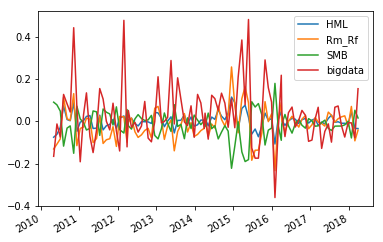

In [34]:
# df_X.describe()
df_X.plot()

In [35]:
X=df_X.values
# np.corrcoef(X,rowvar=False)
X

array([[-3.46934290e-02, -4.21021248e-02,  1.53152448e-02,
         1.53648701e-01],
       [-3.36541893e-02, -9.26328790e-02,  5.18962903e-02,
        -7.78727382e-02],
       [ 4.55635701e-02,  6.98356496e-02, -7.89890783e-02,
        -7.62966960e-03],
       [-1.41736546e-02, -2.33241943e-02, -7.27313241e-05,
        -7.46803954e-03],
       [-9.69824376e-03,  2.55732868e-02, -1.71855358e-02,
        -7.47342040e-02],
       [-9.51340055e-03,  2.07023051e-02, -2.27482976e-02,
        -2.06294264e-02],
       [-2.58050720e-03,  1.17680211e-02, -2.28729924e-02,
         7.20391634e-02],
       [-5.18830273e-03, -4.64361550e-03, -2.31955154e-02,
         6.60585329e-02],
       [ 2.88971018e-02,  2.81985407e-02, -4.34781200e-02,
        -9.87458529e-02],
       [ 1.32327103e-02,  4.30875313e-02, -3.37070063e-02,
        -1.24503036e-02],
       [-1.24536987e-02, -2.31962888e-02,  5.09679561e-03,
        -4.83338040e-02],
       [-4.07021523e-03, -1.09793952e-02, -6.28504901e-03,
      

In [36]:
#get_stocks_r 计算某个数组的股票的收益率Series
#index_date 为观察的数据周期中的日期
#stocks 为要计算的股票数组
#return_data 为总的回报率数据
#df_market_cap 为总的市值数据
def get_stocks_r(index_date,stocks,return_data,df_market_cap):
    s_r = pd.Series(index = index_date)
#     median_size,lmark,hmark=get_div_point(index_date,df_market_cap,btm)
    for date in index_date:
        total_return=0.0
        total_cap=0.0
        for stk in stocks:
            stock_date_cap=df_market_cap[stk][date]
            stock_date_return=return_data[stk][date]*stock_date_cap
            total_cap=total_cap+stock_date_cap
            total_return=total_return+stock_date_return

        s_r[date] = (total_return)/total_cap#每日回报率＝每日总回报/总市值
    return s_r

In [37]:
def get_y(s_y,Rf):
    y = np.array(s_y - Rf)
#     print(y)
    y=y[:data_count-1]
    YT = y.T
    return YT
# y=get_y(return_data_ydyl,Rf)

In [38]:
# str(concept('一带一路'))
arr_ydyl=['000022.XSHE', '000042.XSHE', '000065.XSHE', '000088.XSHE', '000090.XSHE', '000151.XSHE', '000157.XSHE', '000159.XSHE', '000400.XSHE', '000425.XSHE', '000498.XSHE', '000507.XSHE', '000528.XSHE', '000564.XSHE', '000582.XSHE', '000610.XSHE', '000617.XSHE', '000672.XSHE', '000680.XSHE', '000703.XSHE', '000777.XSHE', '000797.XSHE', '000852.XSHE', '000862.XSHE', '000877.XSHE', '000905.XSHE', '000928.XSHE', '000939.XSHE', '000978.XSHE', '600026.XSHG', '600028.XSHG', '600031.XSHG', '600068.XSHG', '600089.XSHG', '600105.XSHG', '600118.XSHG', '600125.XSHG', '600150.XSHG', '600170.XSHG', '600176.XSHG', '600179.XSHG', '600190.XSHG', '600202.XSHG', '600256.XSHG', '600279.XSHG', '600312.XSHG', '600317.XSHG', '600320.XSHG', '600339.XSHG', '600350.XSHG', '600368.XSHG', '600406.XSHG', '600425.XSHG', '600428.XSHG', '600449.XSHG', '600477.XSHG', '600487.XSHG', '600495.XSHG', '600509.XSHG', '600522.XSHG', '600528.XSHG', '600540.XSHG', '600580.XSHG', '600581.XSHG', '600583.XSHG', '600706.XSHG', '600717.XSHG', '600720.XSHG', '600778.XSHG', '600798.XSHG', '600801.XSHG', '600820.XSHG', '600888.XSHG', '600984.XSHG', '002040.XSHE', '600970.XSHG', '002047.XSHE', '002051.XSHE', '600017.XSHG', '600018.XSHG', '601872.XSHG', '601008.XSHG', '002135.XSHE', '601919.XSHG', '002146.XSHE', '601808.XSHG', '601857.XSHG', '601390.XSHG', '601866.XSHG', '002205.XSHE', '002207.XSHE', '601186.XSHG', '601668.XSHG', '002266.XSHE', '601766.XSHG', '601727.XSHG', '601989.XSHG', '002302.XSHE', '002307.XSHE', '002309.XSHE', '601618.XSHG', '601117.XSHG', '300011.XSHE', '002323.XSHE', '002353.XSHE', '601179.XSHG', '601106.XSHG', '002459.XSHE', '300090.XSHE', '300103.XSHE', '601018.XSHG', '002475.XSHE', '601028.XSHG', '002554.XSHE', '002738.XSHE', '601880.XSHG', '002524.XSHE', '300183.XSHE', '601789.XSHG', '300208.XSHE', '300262.XSHE', '601669.XSHG', '601800.XSHG', '603333.XSHG', '603308.XSHG', '300351.XSHE', '603111.XSHG', '600023.XSHG', '300523.XSHE', '300374.XSHE', '603969.XSHG', '603569.XSHG', '603338.XSHG', '603018.XSHG', '603169.XSHG', '002828.XSHE', '603036.XSHG', '603298.XSHG', '603966.XSHG', '603218.XSHG', '601228.XSHG', '600326.XSHG', '603588.XSHG', '603619.XSHG', '600219.XSHG', '300065.XSHE', '002742.XSHE', '600415.XSHG', '603871.XSHG', '300732.XSHE', '600338.XSHG', '600010.XSHG', '600039.XSHG', '601899.XSHG', '002800.XSHE', '601500.XSHG', '300589.XSHE']
if(data_type=="net"):
    arr_ydyl=concept('一带一路')
print('len(arr_ydyl)',len(arr_ydyl))

len(arr_ydyl) 157


In [39]:
# return_data_ydyl=None
# if(data_mode=="fast"):
#     return_data_ydyl=pd.read_csv("return_data_ydyl.csv",index_col=0)
#     return_data_ydyl=trans_index(return_data_ydyl)
# else:
# #     return_data_ydyl=get_return_data(index_date,arr_ydyl,df_price_data)
#     return_data_ydyl=get_stocks_r(index_date,arr_ydyl,return_data,df_market_cap)
return_data_ydyl=get_stocks_r(index_date,arr_ydyl,return_data,df_market_cap)
# return_data_ydyl.to_csv("return_data_ydyl.csv")
return_data_ydyl

2018-03-30   -0.028949
2018-02-28   -0.104921
2018-01-26    0.103772
2017-12-26   -0.019805
2017-11-24   -0.004320
2017-10-24    0.011195
2017-09-22   -0.003050
2017-08-22   -0.000913
2017-07-21    0.055499
2017-06-21    0.014318
2017-05-19   -0.054953
2017-04-19    0.032637
2017-03-17   -0.013705
2017-02-17    0.035753
2017-01-17    0.043298
2016-12-16    0.001903
2016-11-16    0.077130
2016-10-14    0.026541
2016-09-14    0.006522
2016-08-12    0.000897
2016-07-12    0.043105
2016-06-08   -0.006054
2016-05-06   -0.065076
2016-04-06    0.012142
2016-04-01    0.103728
2016-03-01    0.019193
2016-02-01   -0.223980
2015-12-31   -0.007369
2015-11-30   -0.030457
2015-10-30    0.098003
                ...   
2012-09-14   -0.007217
2012-08-14   -0.000178
2012-07-13   -0.055355
2012-06-13   -0.025102
2012-05-11    0.018046
2012-04-11    0.016584
2012-03-30   -0.072500
2012-02-29    0.041254
2012-01-20    0.063403
2011-12-20   -0.063282
2011-11-18    0.008638
2011-10-18   -0.021284
2011-09-16 

In [40]:
YT=get_y(return_data_ydyl,Rf)
X = sm.add_constant(X)
mod = regression.linear_model.OLS(YT, X).fit()
p = mod.params
print(p)
mod.summary()

[-0.02178618  0.46362405  0.11307418 -0.95191788 -0.10934401]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     183.4
Date:                Sat, 02 Jun 2018   Prob (F-statistic):           2.21e-42
Time:                        20:59:07   Log-Likelihood:                 211.05
No. Observations:                  95   AIC:                            -412.1
Df Residuals:                      90   BIC:                            -399.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0218      0.006     -3.659      0.000      -0.034      -0.010
x1             0.4636      0.241      1.924      0.058      -0.015       0.942
x2             0.1131      0.165      0.687      0.494      -0.214       0.440
x3            -0.9519      0.225     -4.238      0.000      -1.398      -0.506
x4            -0.1093      0.030     -3.705      0.000      -0.168      -0.051
==============================================================================
Omnibus:                       22.943   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.962
Skew:                           0.829   Prob(JB):                     1.16e-12
Kurtosis:                       6.337   Cond. No.                         103.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
#np.corrcoef(X)
# np.seterr(divide='ignore', invalid='ignore')
# np.corrcoef(X,rowvar=False)#终于调用成功了，原因时前面的X = sm.add_constant(X)改变了X，已经不是一个简单的3维数组啦，是4列了，而去第一列的数据是：1.00000000e+00所以报错了。
X
# np.corrcoef??

array([[ 1.00000000e+00, -3.46934290e-02, -4.21021248e-02,
         1.53152448e-02,  1.53648701e-01],
       [ 1.00000000e+00, -3.36541893e-02, -9.26328790e-02,
         5.18962903e-02, -7.78727382e-02],
       [ 1.00000000e+00,  4.55635701e-02,  6.98356496e-02,
        -7.89890783e-02, -7.62966960e-03],
       [ 1.00000000e+00, -1.41736546e-02, -2.33241943e-02,
        -7.27313241e-05, -7.46803954e-03],
       [ 1.00000000e+00, -9.69824376e-03,  2.55732868e-02,
        -1.71855358e-02, -7.47342040e-02],
       [ 1.00000000e+00, -9.51340055e-03,  2.07023051e-02,
        -2.27482976e-02, -2.06294264e-02],
       [ 1.00000000e+00, -2.58050720e-03,  1.17680211e-02,
        -2.28729924e-02,  7.20391634e-02],
       [ 1.00000000e+00, -5.18830273e-03, -4.64361550e-03,
        -2.31955154e-02,  6.60585329e-02],
       [ 1.00000000e+00,  2.88971018e-02,  2.81985407e-02,
        -4.34781200e-02, -9.87458529e-02],
       [ 1.00000000e+00,  1.32327103e-02,  4.30875313e-02,
        -3.37070063e-02

In [42]:
# df_bigdata_origin=pd.read_csv("bigdata.csv",encoding="gbk",index_col=0)
# df_bigdata_origin
# df_bigdata=pd.Series(df_bigdata_origin["收盘点位"],index=df_bigdata_origin.index,name="bigdata")
# # df_bigdata["close"]=df_bigdata_origin["收盘点位"]
# df_bigdata.index.name="index_date"
# df_bigdata.to_csv("bigdata_close.csv")
# df_bigdata=trans_index(df_bigdata)
# df_bigdata2=df_bigdata[df_bigdata.index.isin(index_date)]
# df_bigdata2.to_csv("bigdata_pure.csv")
# df_bigdata=pd.read_csv("bigdata_pure.csv",index_col=0,header=None)
# df_bigdata["test"]=df_bigdata_origin["收盘点位"]
# df_bigdata

In [43]:
price_data=get_price_cs(data_starttime,data_endtime)
price_data

603186.XSHG  000062.XSHE  300643.XSHE  600315.XSHG  300146.XSHE  \
2010-04-02          NaN       9.6163          NaN      18.0081          NaN   
2010-04-06          NaN       9.5244          NaN      18.5700          NaN   
2010-04-07          NaN       9.4234          NaN      18.5747          NaN   
2010-04-08          NaN       9.4693          NaN      19.1133          NaN   
2010-04-09          NaN       9.6347          NaN      19.2201          NaN   
2010-04-12          NaN       9.7724          NaN      19.9120          NaN   
2010-04-13          NaN       9.4785          NaN      20.1860          NaN   
2010-04-14          NaN      10.4245          NaN      19.8335          NaN   
2010-04-15          NaN      10.1857          NaN      19.4014          NaN   
2010-04-16          NaN       9.9561          NaN      20.1074          NaN   
2010-04-19          NaN       9.8459          NaN      19.9613          NaN   
2010-04-20          NaN      10.4613          NaN      20.2656          NaN   
2010-04-21          NaN      10.7460          NaN      21.1298          NaN   
2010-04-22          NaN      10.9297          NaN      22.9859          NaN   
2010-04-23          NaN      10.7184          NaN      22.1887          NaN   
2010-04-26          NaN      10.5715          NaN      22.1157          NaN   
2010-04-27          NaN      10.5715          NaN      21.6653          NaN   
2010-04-28          NaN      10.2959          NaN      21.0507          NaN   
2010-04-29          NaN       9.4234          NaN      19.8274          NaN   
2010-04-30          NaN       9.1203          NaN      20.1195          NaN   
2010-05-04          NaN       9.1571          NaN      20.6733          NaN   
2010-05-05          NaN       9.4601          NaN      20.9229          NaN   
2010-05-06          NaN       9.0836          NaN      20.5638          NaN   
2010-05-07          NaN       8.8080          NaN      20.3873          NaN   
2010-05-10          NaN       8.6519          NaN      19.0728          NaN   
2010-05-11          NaN       8.4682          NaN      18.5555          NaN   
2010-05-12          NaN       8.2294          NaN      19.2736          NaN   
2010-05-13          NaN       8.3764          NaN      19.9857          NaN   
2010-05-14          NaN       8.3488          NaN      19.8944          NaN   
2010-05-17          NaN       7.9079          NaN      19.4744          NaN   
...                 ...          ...          ...          ...          ...   
2018-02-12        18.76      18.3291      10.2460      33.3800         16.6   
2018-02-13        18.26      18.7130      10.1965      34.3400         16.6   
2018-02-14        18.28      18.6244      10.1172      34.1100         16.6   
2018-02-22        20.11      19.0181      10.2659      34.0900         16.6   
2018-02-23        21.79      19.3725      10.2956      34.0300         16.6   
2018-02-26        22.13      19.6087      10.6127      34.5900         16.6   
2018-02-27        22.40      19.5891      10.6820      34.1100         16.6   
2018-02-28        22.21      19.4709      10.5830      34.0100         16.6   
2018-03-01        22.64      19.8745      10.8208      34.1700         16.6   
2018-03-02        21.99      19.5201      10.8703      34.6500         16.6   
2018-03-05        22.42      19.7367      11.1775      34.5100         16.6   
2018-03-06        22.37      20.2584      11.1081      34.9900         16.6   
2018-03-07        22.42      19.8450      10.9694      34.7000         16.6   
2018-03-08        22.14      20.3076      11.3063      34.8200         16.6   
2018-03-09        23.13      20.5045      11.6928      34.9400         16.6   
2018-03-12        24.39      20.8589      12.5351      35.3800         16.6   
2018-03-13        24.02      21.2822      12.1882      34.9000         16.6   
2018-03-14        23.55      20.5833      12.9017      34.7800         16.6   
2018-03-15        22.71      20.4061      12.1387      35.0100

In [44]:
len(price_data.columns)

3631

In [45]:
len(stocks)

3513

In [46]:
# price_data[stocks]
# price_data[not ]
# price_data[]
# np.all(np.any(price_data,axis=1))#==true
# price_data[1940:].groupby("603186.XSHG").size()#np.nan不参与计算，所以无法得出np.nan的个数
# ss=price_data["603186.XSHG"]
# type(ss[0])#np.nan!=NaN,  type(NaN)==numpy.float64
# ss[np.isnan(ss)]

In [47]:
price_data.dropna(axis=1,how='all') 

603186.XSHG  000062.XSHE  300643.XSHE  600315.XSHG  300146.XSHE  \
2010-04-02          NaN       9.6163          NaN      18.0081          NaN   
2010-04-06          NaN       9.5244          NaN      18.5700          NaN   
2010-04-07          NaN       9.4234          NaN      18.5747          NaN   
2010-04-08          NaN       9.4693          NaN      19.1133          NaN   
2010-04-09          NaN       9.6347          NaN      19.2201          NaN   
2010-04-12          NaN       9.7724          NaN      19.9120          NaN   
2010-04-13          NaN       9.4785          NaN      20.1860          NaN   
2010-04-14          NaN      10.4245          NaN      19.8335          NaN   
2010-04-15          NaN      10.1857          NaN      19.4014          NaN   
2010-04-16          NaN       9.9561          NaN      20.1074          NaN   
2010-04-19          NaN       9.8459          NaN      19.9613          NaN   
2010-04-20          NaN      10.4613          NaN      20.2656          NaN   
2010-04-21          NaN      10.7460          NaN      21.1298          NaN   
2010-04-22          NaN      10.9297          NaN      22.9859          NaN   
2010-04-23          NaN      10.7184          NaN      22.1887          NaN   
2010-04-26          NaN      10.5715          NaN      22.1157          NaN   
2010-04-27          NaN      10.5715          NaN      21.6653          NaN   
2010-04-28          NaN      10.2959          NaN      21.0507          NaN   
2010-04-29          NaN       9.4234          NaN      19.8274          NaN   
2010-04-30          NaN       9.1203          NaN      20.1195          NaN   
2010-05-04          NaN       9.1571          NaN      20.6733          NaN   
2010-05-05          NaN       9.4601          NaN      20.9229          NaN   
2010-05-06          NaN       9.0836          NaN      20.5638          NaN   
2010-05-07          NaN       8.8080          NaN      20.3873          NaN   
2010-05-10          NaN       8.6519          NaN      19.0728          NaN   
2010-05-11          NaN       8.4682          NaN      18.5555          NaN   
2010-05-12          NaN       8.2294          NaN      19.2736          NaN   
2010-05-13          NaN       8.3764          NaN      19.9857          NaN   
2010-05-14          NaN       8.3488          NaN      19.8944          NaN   
2010-05-17          NaN       7.9079          NaN      19.4744          NaN   
...                 ...          ...          ...          ...          ...   
2018-02-12        18.76      18.3291      10.2460      33.3800         16.6   
2018-02-13        18.26      18.7130      10.1965      34.3400         16.6   
2018-02-14        18.28      18.6244      10.1172      34.1100         16.6   
2018-02-22        20.11      19.0181      10.2659      34.0900         16.6   
2018-02-23        21.79      19.3725      10.2956      34.0300         16.6   
2018-02-26        22.13      19.6087      10.6127      34.5900         16.6   
2018-02-27        22.40      19.5891      10.6820      34.1100         16.6   
2018-02-28        22.21      19.4709      10.5830      34.0100         16.6   
2018-03-01        22.64      19.8745      10.8208      34.1700         16.6   
2018-03-02        21.99      19.5201      10.8703      34.6500         16.6   
2018-03-05        22.42      19.7367      11.1775      34.5100         16.6   
2018-03-06        22.37      20.2584      11.1081      34.9900         16.6   
2018-03-07        22.42      19.8450      10.9694      34.7000         16.6   
2018-03-08        22.14      20.3076      11.3063      34.8200         16.6   
2018-03-09        23.13      20.5045      11.6928      34.9400         16.6   
2018-03-12        24.39      20.8589      12.5351      35.3800         16.6   
2018-03-13        24.02      21.2822      12.1882      34.9000         16.6   
2018-03-14        23.55      20.5833      12.9017      34.7800         16.6   
2018-03-15        22.71      20.4061      12.1387      35.0100

In [48]:
# price_data.apply(lambda x:x)
# np.percentile([1,2,np.nan,4,5],40)
# price_data.dropna(axis=1,how='all') 
price_data.dropna(axis=1,thresh=len(price_data.index)) 

000062.XSHE  600315.XSHG  000990.XSHE  600551.XSHG  002245.XSHE  \
2010-04-02       9.6163      18.0081      14.8820      15.5627       2.3894   
2010-04-06       9.5244      18.5700      15.1620      15.2372       2.4055   
2010-04-07       9.4234      18.5747      15.5483      15.3205       2.4945   
2010-04-08       9.4693      19.1133      15.6449      15.8049       2.7439   
2010-04-09       9.6347      19.2201      15.7801      15.8503       2.7877   
2010-04-12       9.7724      19.9120      16.1567      16.4786       2.8489   
2010-04-13       9.4785      20.1860      15.6932      16.4862       2.6622   
2010-04-14      10.4245      19.8335      15.7608      17.1674       2.7672   
2010-04-15      10.1857      19.4014      15.9153      16.7662       2.8592   
2010-04-16       9.9561      20.1074      16.6106      16.4634       2.8664   
2010-04-19       9.8459      19.9613      16.2340      15.7822       2.7702   
2010-04-20      10.4613      20.2656      17.1321      16.1834       2.7454   
2010-04-21      10.7460      21.1298      17.3446      16.8873       2.9160   
2010-04-22      10.9297      22.9859      17.4122      16.8873       2.8475   
2010-04-23      10.7184      22.1887      16.2823      16.8343       2.8475   
2010-04-26      10.5715      22.1157      16.0891      17.2582       2.7643   
2010-04-27      10.5715      21.6653      16.4851      16.7057       2.6826   
2010-04-28      10.2959      21.0507      16.5720      16.7057       2.6447   
2010-04-29       9.4234      19.8274      15.5000      15.4946       2.5411   
2010-04-30       9.1203      20.1195      15.1137      14.2683       2.4799   
2010-05-04       9.1571      20.6733      15.1620      14.3970       2.4945   
2010-05-05       9.4601      20.9229      15.3648      14.8890       2.6097   
2010-05-06       9.0836      20.5638      15.3552      14.5333       2.4843   
2010-05-07       8.8080      20.3873      14.4377      14.4197       2.4755   
2010-05-10       8.6519      19.0728      12.9988      13.7082       2.4551   
2010-05-11       8.4682      18.5555      12.3131      13.0799       2.4376   
2010-05-12       8.2294      19.2736      12.3421      12.7771       2.3019   
2010-05-13       8.3764      19.9857      12.5932      13.2692       2.3603   
2010-05-14       8.3488      19.8944      12.8153      13.2237       2.3705   
2010-05-17       7.9079      19.4744      11.7820      12.6863       2.1414   
...                 ...          ...          ...          ...          ...   
2018-02-12      18.3291      33.3800      15.2600      11.3400       8.8432   
2018-02-13      18.7130      34.3400      15.2600      11.3400       8.4150   
2018-02-14      18.6244      34.1100      15.2500      11.4900       8.3353   
2018-02-22      19.0181      34.0900      15.3700      11.6400       8.4847   
2018-02-23      19.3725      34.0300      15.5400      11.6700       8.4448   
2018-02-26      19.6087      34.5900      15.8400      11.7900       8.8631   
2018-02-27      19.5891      34.1100      15.6700      11.7000       8.9328   
2018-02-28      19.4709      34.0100      15.8000      11.8000       8.9826   
2018-03-01      19.8745      34.1700      15.9400      11.9100       9.1121   
2018-03-02      19.5201      34.6500      15.9000      11.8200       8.8930   
2018-03-05      19.7367      34.5100      15.8300      11.9900       9.0722   
2018-03-06      20.2584      34.9900      16.2200      12.0200       9.0921   
2018-03-07      19.8450      34.7000      16.0500      11.8200       9.1917   
2018-03-08      20.3076      34.8200      16.3900      11.8200       9.0822   
2018-03-09      20.5045      34.9400      16.6900      12.0000       9.2813   
2018-03-12      20.8589      35.3800      16.8300      12.1900       9.6100   
2018-03-13      21.2822      34.9000      16.8500      12.1500       9.5403   
2018-03-14      20.5833      34.7800      16.8100      12.1800       9.5502   
2018-03-15      20.4061      35.0100      16.8600      12.1100